In [1]:
from deepforest import main
from deepforest import get_data
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch


/Users/iosefa/repos/obia/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from deepforest import main
from deepforest import get_data
import matplotlib.pyplot as plt

model = main.deepforest()
model.load_model(model_name="weecology/deepforest-tree", revision="main")
model.config['retinanet']["score_thresh"] = 0.05

Reading config file: /Users/iosefa/repos/obia/venv/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Reading config file: /Users/iosefa/repos/obia/venv/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [23]:
from obia.handlers.geotif import open_geotiff

raster_location = "/Users/iosefa/repos/hawaii-landcover/puuwaawaa/data/clip3.tif"
raster = open_geotiff(raster_location)
img_norm = raster.to_image([4,2,1])

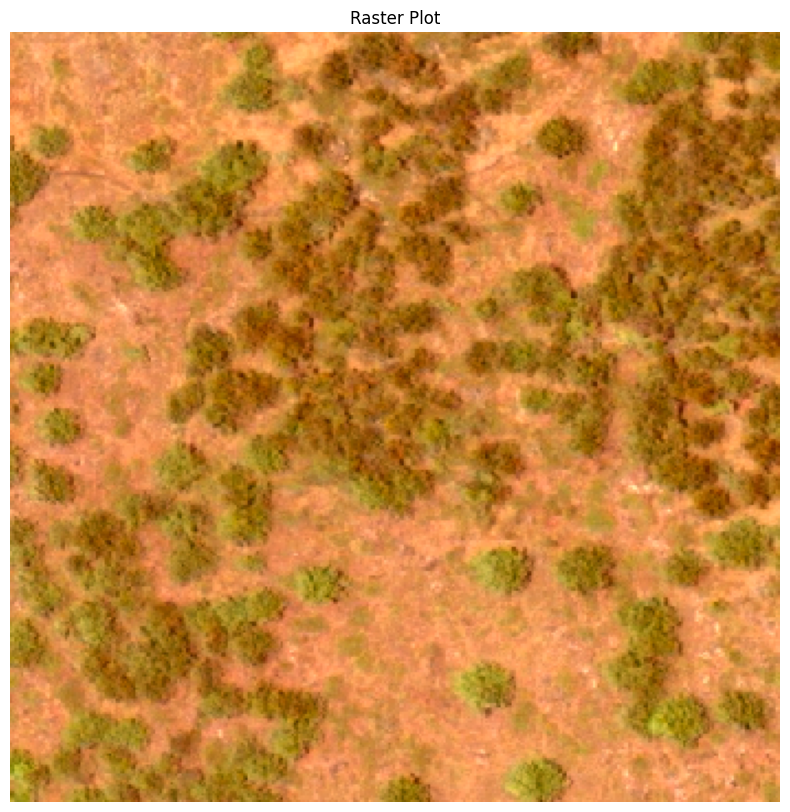

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(img_norm)
plt.title('Raster Plot')
plt.axis('off')  # Hide axis
plt.show()

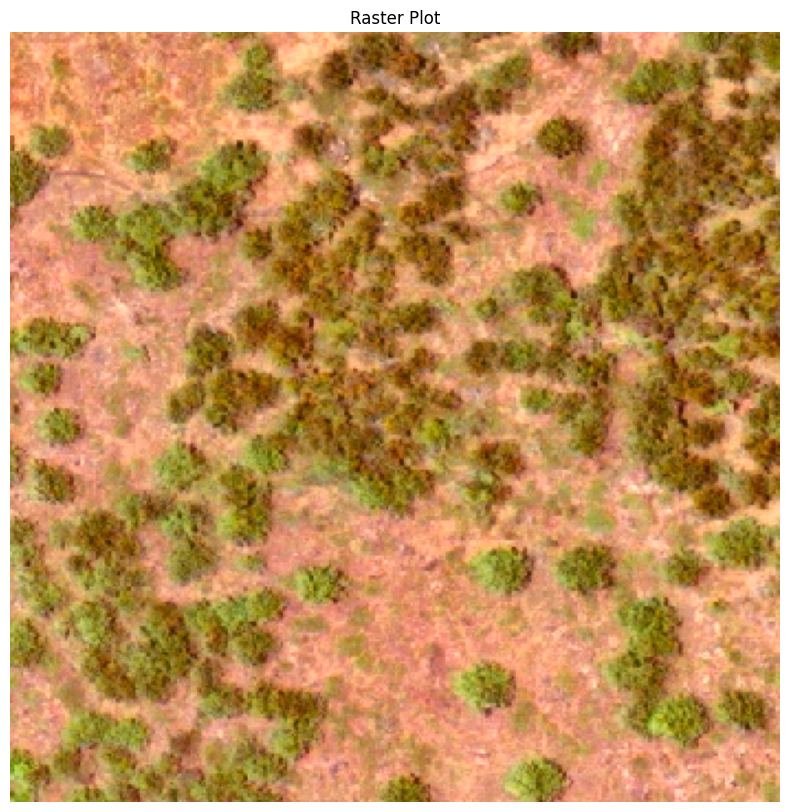

In [25]:
img = raster.to_image([4,2,1], stretch_type="clahe")

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title('Raster Plot')
plt.axis('off')  # Hide axis
plt.show()

In [26]:
import os
from PIL import Image


img.save("/Users/iosefa/repos/hawaii-landcover/puuwaawaa/data/closeup.png")

Reading config file: /Users/iosefa/repos/obia/venv/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Reading config file: /Users/iosefa/repos/obia/venv/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


(48, 8)
    xmin   ymin   xmax   ymax label     score   image_path  \
0  224.0  325.0  251.0  348.0  Tree  0.654045  closeup.png   
1  200.0  283.0  227.0  306.0  Tree  0.626480  closeup.png   
2  127.0  242.0  149.0  258.0  Tree  0.474192  closeup.png   
3  303.0    0.0  324.0    6.0  Tree  0.454333  closeup.png   
4  292.0  300.0  316.0  322.0  Tree  0.432617  closeup.png   

                                            geometry  
0  POLYGON ((251 325, 251 348, 224 348, 224 325, ...  
1  POLYGON ((227 283, 227 306, 200 306, 200 283, ...  
2  POLYGON ((149 242, 149 258, 127 258, 127 242, ...  
3      POLYGON ((324 0, 324 6, 303 6, 303 0, 324 0))  
4  POLYGON ((316 300, 316 322, 292 322, 292 300, ...  


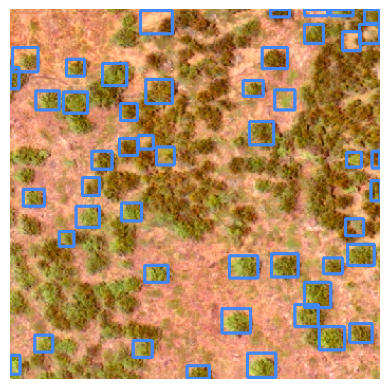

In [28]:
from deepforest import main, visualize

model = main.deepforest()
model.load_model(model_name="weecology/deepforest-tree", revision="main")
model.config['retinanet']["score_thresh"] = 0.65

trees = model.predict_image(path="/Users/iosefa/repos/hawaii-landcover/puuwaawaa/data/closeup.png")

print(trees.shape)
print(trees.head())
visualize.plot_results(trees)


In [29]:
import math
import os
import glob
import time

import numpy as np
import numpy.lib.recfunctions as rfn

import geopandas as gpd
from obia.handlers.geotif import open_geotiff, open_binary_geotiff_as_mask
from obia.segmentation.segment_statistics import create_objects
from obia.segmentation.segment_boundaries import create_segments


start_time = time.time()

input_mask = "/Users/iosefa/repos/hawaii-landcover/puuwaawaa/data/clip3_mask.tif"

area_threshold = np.pi ** 2

mask, _, _, _= open_binary_geotiff_as_mask(input_mask)
crown_radius = 2.5
pixel_area = 0.5 ** 2
crown_area = math.pi * (crown_radius ** 2)
tree_area = mask.sum() * pixel_area
n_crowns = round(tree_area / crown_area)
n_segments = n_crowns

segments = create_segments(
    raster,
    segmentation_bands=None,
    mask=mask,
    compactness=0.27,
    n_segments=n_segments,
    sigma=0,
    convert2lab=False,
    slic_zero=False
)
segments.to_file('/Users/iosefa/repos/hawaii-landcover/puuwaawaa/data/clip3_segments.gpkg')

elapsed_time = time.time() - start_time
print(f"Time taken: {elapsed_time:.6f} seconds")

Shape of img_to_segment: (350, 350, 9)
Time taken: 1.243926 seconds


In [35]:
import geopandas as gpd

# Load the GeoPackages
boxes_gdf = gpd.read_file('/Users/iosefa/repos/hawaii-landcover/puuwaawaa/data/boxes_manual.gpkg')
polygons_gdf = gpd.read_file('/Users/iosefa/repos/hawaii-landcover/puuwaawaa/data/clip3_segments.gpkg')

boxes_gdf['fid'] = range(1, len(boxes_gdf) + 1)

print(boxes_gdf.columns)

# Ensure both GeoDataFrames have the same CRS
if boxes_gdf.crs != polygons_gdf.crs:
    polygons_gdf = polygons_gdf.to_crs(boxes_gdf.crs)

# Function to assign fid based on the rules
def assign_fid(polygon, boxes_gdf):
    # Intersecting FIDs
    intersecting_boxes = boxes_gdf[boxes_gdf.intersects(polygon.geometry)]
    
    if not intersecting_boxes.empty:
        # Calculate intersection areas
        intersecting_boxes['intersect_area'] = intersecting_boxes.apply(
            lambda row: polygon.geometry.intersection(row.geometry).area, axis=1
        )
        # Take the box with the largest intersection area
        max_area_box = intersecting_boxes.loc[intersecting_boxes['intersect_area'].idxmax()]
        return max_area_box['fid']
    
    # If no intersections, look for touching polygons
    touching_boxes = boxes_gdf[boxes_gdf.touches(polygon.geometry)]
    
    if not touching_boxes.empty:
        # Calculate touching lengths
        touching_boxes['touch_length'] = touching_boxes.apply(
            lambda row: polygon.geometry.boundary.intersection(row.geometry.boundary).length, axis=1
        )
        # Take the box with the longest touching length
        max_length_box = touching_boxes.loc[touching_boxes['touch_length'].idxmax()]
        return max_length_box['fid']
    
    return None

# Apply the function to each polygon
polygons_gdf['assigned_fid'] = polygons_gdf.apply(assign_fid, axis=1, boxes_gdf=boxes_gdf)

# Save the result to a new GeoPackage
output_path = '/Users/iosefa/repos/hawaii-landcover/puuwaawaa/data/clip3_segments_with_fid.gpkg'
polygons_gdf.to_file(output_path, driver='GPKG')

print(f"Output saved to {output_path}")

Index(['geometry', 'fid'], dtype='object')
Output saved to /Users/iosefa/repos/hawaii-landcover/puuwaawaa/data/clip3_segments_with_fid.gpkg
